# Exploratory Data Analysis

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

pd.set_option("display.max_columns", 200)

PROJECT_ROOT = "/Users/luigicheng/Desktop/ibm-fraud-capstone"
os.chdir(PROJECT_ROOT)

def load_transactions(filename, sample_frac=None, random_state=42):
    path = os.path.join("data/raw", filename)
    
    if sample_frac is None:
        return pd.read_csv(path)
    
    return pd.read_csv(path).sample(frac=sample_frac, random_state=random_state)

def load_transactions_fast(filename, n_rows=None, random_state=42):
    path = os.path.join("data/raw", filename)
    
    if n_rows is None:
        return pd.read_csv(path)
    
    header = pd.read_csv(path, nrows=0).columns
    
    rng = np.random.default_rng(random_state)
    skip = rng.choice(
        np.arange(1, 10_000_000),
        size=10_000_000 - n_rows,
        replace=False
    )
    
    skip = set(skip)
    
    return pd.read_csv(path, skiprows=skip, names=header)

def null_summary(df):
    null_counts = df.isna().sum()
    null_rates = df.isna().mean()
    
    summary = pd.DataFrame({
        "null_count": null_counts,
        "null_rate": null_rates
    }).sort_values("null_rate", ascending=False)
    
    return summary[summary["null_count"] > 0]


def duplicate_check(df):
    total = len(df)
    dup_all = df.duplicated().sum()
    
    return {
        "total_rows": total,
        "duplicate_rows": dup_all,
        "duplicate_rate": dup_all / total
    }

def numeric_sanity(df):
    cols = ["Amount Paid", "Amount Received"]
    out = {}
    
    for c in cols:
        series = pd.to_numeric(df[c], errors="coerce")
        out[c] = {
            "min": series.min(),
            "max": series.max(),
            "zeros": (series == 0).sum(),
            "negatives": (series < 0).sum()
        }
    return pd.DataFrame(out)

def timestamp_summary(df, time_col="Timestamp"):
    ts = pd.to_datetime(df[time_col], errors="coerce")
    
    return {
        "min_time": ts.min(),
        "max_time": ts.max(),
        "null_timestamps": ts.isna().sum()
    }

def account_bank_summary(df):
    return {
        "unique_from_accounts": df["From Account"].nunique(),
        "unique_to_accounts": df["To Account"].nunique(),
        "unique_banks_from": df["From Bank"].nunique(),
        "unique_banks_to": df["To Bank"].nunique(),
    }

def dataset_overview(df, name):
    return {
        "dataset": name,
        "rows": len(df),
        "laundering_rate": df["Is Laundering"].mean(),
        "unique_accounts": pd.concat([
            df["From Account"], df["To Account"]
        ]).nunique(),
        "unique_banks": pd.concat([
            df["From Bank"], df["To Bank"]
        ]).nunique()
    }

def plot_label_distribution(df, title):
    counts = df["Is Laundering"].value_counts()
    rates = df["Is Laundering"].value_counts(normalize=True)

    print(counts)
    print()
    print(rates)

    plt.figure()
    counts.plot(kind="bar")
    plt.title(title)
    plt.ylabel("Count")
    plt.show()

In [2]:
# df_small = load_transactions("HI-Small_Trans.csv")
# df_medium = load_transactions("HI-Medium_Trans.csv")
# df_large = load_transactions("HI-Large_Trans.csv")

In [3]:
df_small  = load_transactions_fast("HI-Small_Trans.csv")
df_medium = load_transactions_fast("HI-Medium_Trans.csv", 1_000_000)
df_large  = load_transactions_fast("HI-Large_Trans.csv", 500_000)

/var/folders/zl/405wf3ns5b9gspbwgsg925sr0000gn/T/ipykernel_69023/910803284.py:37: DtypeWarning: Columns (1,3,5,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, skiprows=skip, names=header)
/var/folders/zl/405wf3ns5b9gspbwgsg925sr0000gn/T/ipykernel_69023/910803284.py:37: DtypeWarning: Columns (1,3,5,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, skiprows=skip, names=header)


## HI-Small

In [4]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


Is Laundering
0    5073168
1       5177
Name: count, dtype: int64

Is Laundering
0    0.998981
1    0.001019
Name: proportion, dtype: float64


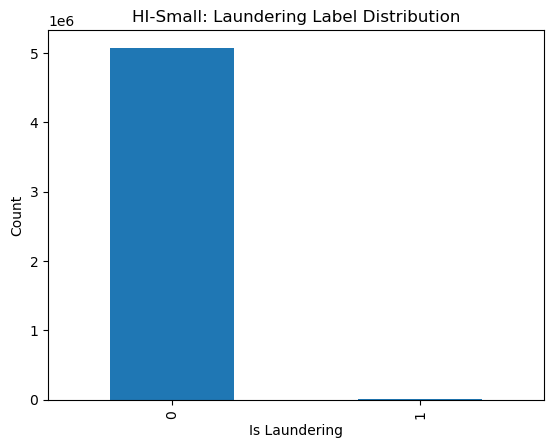

In [15]:
plot_label_distribution(df_small, "HI-Small: Laundering Label Distribution")

In [13]:
null_summary(df_small)

,null_count,null_rate


In [14]:
duplicate_check(df_small)

{'total_rows': 5078345,
 'duplicate_rows': np.int64(9),
 'duplicate_rate': np.float64(1.7722309138114878e-06)}

In [24]:
numeric_sanity(df_small)

,Amount Paid,Amount Received
min,1.000000e-06,1.000000e-06
max,1.046302e+12,1.046302e+12
zeros,0.000000e+00,0.000000e+00
negatives,0.000000e+00,0.000000e+00


In [25]:
timestamp_summary(df_small)

{'min_time': Timestamp('2022-09-01 00:00:00'),
 'max_time': Timestamp('2022-09-18 16:18:00'),
 'null_timestamps': np.int64(0)}

## HI-Medium

In [6]:
df_medium.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22898239 entries, 0 to 22898238
Data columns (total 11 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   Timestamp           object
 1   From Bank           object
 2   Account             object
 3   To Bank             object
 4   Account.1           object
 5   Amount Received     object
 6   Receiving Currency  object
 7   Amount Paid         object
 8   Payment Currency    object
 9   Payment Format      object
 10  Is Laundering       object
dtypes: object(11)
memory usage: 1.9+ GB


Is Laundering
0                22805975
0                   65527
1                   26728
1                       8
Is Laundering           1
Name: count, dtype: int64

Is Laundering
0                9.959707e-01
0                2.861661e-03
1                1.167251e-03
1                3.493718e-07
Is Laundering    4.367148e-08
Name: proportion, dtype: float64


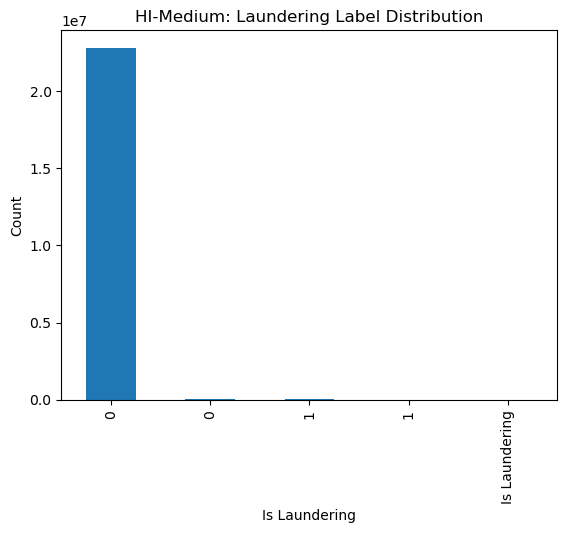

In [16]:
plot_label_distribution(df_medium, "HI-Medium: Laundering Label Distribution")

In [19]:
df_medium['Is Laundering'].unique()

array(['Is Laundering', '0', '1', 0, 1], dtype=object)

In [20]:
null_summary(df_medium)

,null_count,null_rate


In [27]:
numeric_sanity(df_medium)

,Amount Paid,Amount Received
min,1.000000e-06,1.000000e-06
max,2.046160e+12,2.046160e+12
zeros,0.000000e+00,0.000000e+00
negatives,0.000000e+00,0.000000e+00


In [28]:
duplicate_check(df_medium)

{'total_rows': 22898239,
 'duplicate_rows': np.int64(17),
 'duplicate_rate': np.float64(7.424151700049947e-07)}

In [29]:
timestamp_summary(df_medium)

/var/folders/zl/405wf3ns5b9gspbwgsg925sr0000gn/T/ipykernel_69023/352260752.py:76: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(df[time_col], errors="coerce")


{'min_time': Timestamp('2022-09-01 00:00:00'),
 'max_time': Timestamp('2022-09-28 15:58:00'),
 'null_timestamps': np.int64(1)}

## HI-Large

In [8]:
df_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170202230 entries, 0 to 170202229
Data columns (total 11 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   Timestamp           object
 1   From Bank           object
 2   Account             object
 3   To Bank             object
 4   Account.1           object
 5   Amount Received     object
 6   Receiving Currency  object
 7   Amount Paid         object
 8   Payment Currency    object
 9   Payment Format      object
 10  Is Laundering       object
dtypes: object(11)
memory usage: 13.9+ GB


Is Laundering
0                169919048
1                   217646
0                    65528
1                        7
Is Laundering            1
Name: count, dtype: int64

Is Laundering
0                9.983362e-01
1                1.278749e-03
0                3.850008e-04
1                4.112755e-08
Is Laundering    5.875364e-09
Name: proportion, dtype: float64


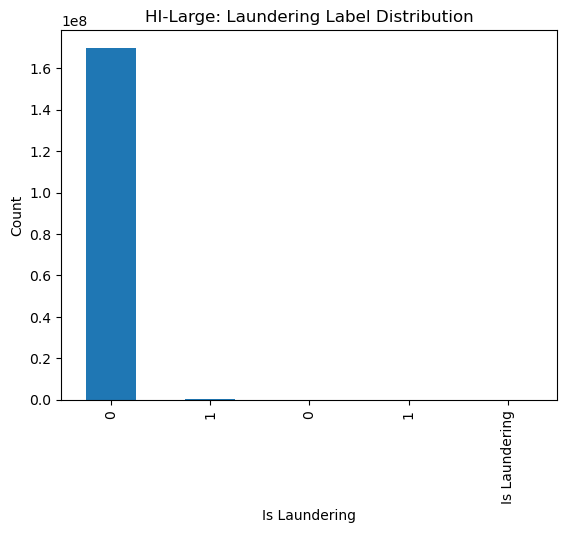

In [9]:
plot_label_distribution(df_large, "HI-Large: Laundering Label Distribution")

In [22]:
null_summary(df_large)

,null_count,null_rate


In [23]:
# Overview

overview = pd.DataFrame([
    dataset_overview(df_small, "HI-Small"),
    dataset_overview(df_medium, "HI-Medium (sampled)"),
    dataset_overview(df_large, "HI-Large (sampled)")
])

overview

## Takeaway

The vast majority of transactions are non-laundering, making transaction-level classification highly imbalanced and prone to false positives.

## Degree distribution

In [10]:
def compute_degrees(df):
    senders = df["From Account"]
    receivers = df["To Account"]
    all_nodes = pd.concat([senders, receivers])
    return all_nodes.value_counts()

def plot_degree_distribution(degrees, title):
    plt.figure()
    plt.hist(np.log1p(degrees.values), bins=100)
    plt.title(title)
    plt.xlabel("log1p(degree)")
    plt.ylabel("Number of accounts")
    plt.show()
    
def laundering_degree_focus(df):
    laundering_df = df[df["Is Laundering"] == 1]
    laundering_nodes = pd.concat([
        laundering_df["From Account"],
        laundering_df["To Account"]
    ])
    return laundering_nodes.value_counts()

## HI-Small

In [11]:
laundering_deg = laundering_degree_focus(df_small)

plt.figure()
plt.hist(np.log1p(laundering_deg.values), bins=50)
plt.title("HI-Small: Degrees of Accounts Involved in Laundering")
plt.xlabel("log1p(degree)")
plt.ylabel("Count")
plt.show()

KeyError: 'From Account'

In [ ]:
## HI-Medium

In [ ]:
## HI-Large